## Things do not understand

1. sequential API vs functional API
2. Siamese Neural Network
3. convolution neural network
4. Memory growth of GPU 
5. virtual environment
6. Scaling
7. data.cache()
8. train_data.prefetch(8)

## New things

1. checking my GPU
2. moving files
3. cv2
4. each python version works with TF version
5. using tf.data.Dataset
6. zip and *
7. tf.data.Dataset.from_tensor_slices

# Setup

## Install Dependencies

In [1]:
%pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## import dependencies

Standerd dependancies

In [2]:
# opencv will give us image process capabilities, and we needs it for testing
import cv2
# it abstact the OS from our python code! makes it a whole heap, and easier to work with different directories and different file paths
import os
# ganerate random data
import random
# great when working with arrays
import numpy as np
# visualization
from matplotlib import pyplot as plt

### Transorflow Ddpendencies

there is a sequintial API, and functional API. fancional API, usefull for hardcore deep learning models


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

Model: Model(inputs=[inputimage, verificationimage], outputs=[0,1])

Layer: high level class, allows to define a cusom layer, class L1Dist(Layer)

Conv2v: allow convolution, convolutional nural newtwork

Dense: give us fully connected layer

MaxPooling: shrinks the information 

Input: Input(shape=)

flatten: flatten the data into a single dimension layer, allows to pass the convolutional neural network data to dense layer

## Set GPU Growth

limite how much vram tensorflow can use, don't let TF to go crazy

In [4]:
# avoind OOM errors by setting GPU Memory Consumption Growth
# giting all available GPUs on our machien
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
len(gpus)

0

## Create folder Structures

Ancher: Unknown Input

Positive: What should match

Nigative: What should not match

In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchoer')

In [7]:
# Mke the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect positive and anchor data

## Untar the dataset, Collect Negative data

In [8]:
# uncompress the database
!tar -xf lfw.tgz

In [9]:
# move dataset to the negative directory

for dir in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', dir)):
    EX_PATH = os.path.join('lfw', dir, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

## Collect Positive and Anchor data

That will be done using the openCV to access the camera 

In [6]:
# import uuid, universally unique identity identifier, to generate unique image names
import uuid

In [8]:
# establish connection with webcam
#0 for your primary camera and 1 for your secondary camera
cap = cv2.VideoCapture(0)
# loop on every frame in our webcam
print(cap.isOpened())
while cap.isOpened():
    # unpack the result
    # ret: returned value!
    # frame: actual frame, the actual image
    ret, frame = cap.read()

    # 2. Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250, :]
    
    # 3. Collect anchor and positive
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create image name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out image
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create image name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out image
        cv2.imwrite(imgname, frame)
        
    # to see what we doing, it shows the image back to the screen
    # showing the feed from the webcam on the screen or inside cv2 frame
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    # waitKey(1): wait 1ms
    # 0xFF == ord('q'): checking what key is being pressed,
    # unpacking what is being pressed from our keyboard
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release the webcam
cap.release()
# close the image show frame
cv2.destroyAllWindows()

True


In [9]:
frame.shape 

(250, 250, 3)

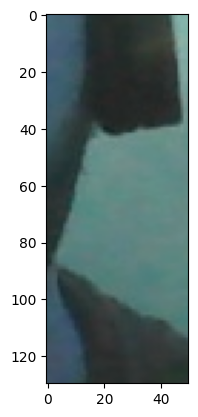

In [10]:
# frame[x, y, channels]
plt.imshow(frame[120:120+250, 200:200+250, :])

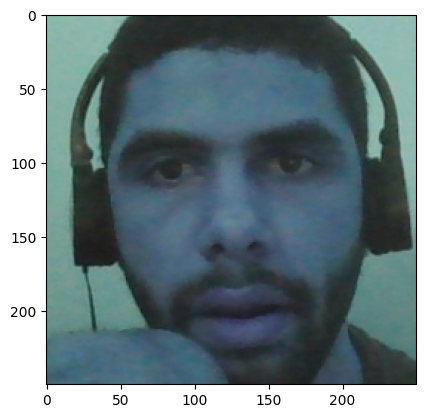

In [11]:
# frame before cut, the color looks diffrent because openCV have a different channel order
plt.imshow(frame)

# 3. Load and Preprocessing Images

## 3.1 Get image directories

In [84]:

# using a generator te be able to loop through specific directory
# creates a set or pipeline for files in this directory
# it loads the image path not the image itself
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [13]:
ANC_PATH + '\*.jpg'

'data\\anchoer\\*.jpg'

In [14]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchoer\\677c2477-3bb4-11ed-9313-7c8ae18b9df3.jpg'

### How we gonna train:

1. take a batch
2. calculate error/lost
3. calculate the gradients
4. update wights by apply the uprated gradients

this data pipeline or as_numpy_iterator allows us to this

## 3.2. PreProcessing - Scale and Resize

1. loads our images from directory
2. resize it
3. perform some scaling

Converting all images value from (255-0) to (1-0), to optimize performance of neural network for get the gradient descent

**this our goal:** dataset_generator.map(preprocessing_function)

In [15]:
def preprocess(file_path):

    # Read in image, as a bytes-like object, from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps
    # 1. resizing the image to be 100x100
    img = tf.image.resize(img,(100,100))
    # 2. Scale image to be between 0 and 1
    img /= 255.0
    return img

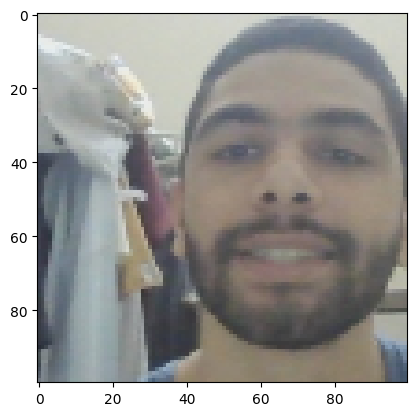

In [17]:
img = preprocess('data\\anchoer\\677c2477-3bb4-11ed-9313-7c8ae18b9df3.jpg')
plt.imshow(img)

In [18]:
img.numpy().max()

0.94264704

## 3.3 Create Labelled Dataset

we gonna pass anchor with positive or negative image and get 1's or 0's

(anchor, positive) => 1,1,1,1,1

(anchor, negative) => 0,0,0,0,0

In [61]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [62]:
class_labels = tf.data.Dataset.from_tensor_slices([1,2,3,4])
iterator_labels = class_labels.as_numpy_iterator()

In [63]:
iterator_labels.next()

1

In [85]:
# zip to iterate the three of them at the same time 
positive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data =  positive.concatenate(negative)

In [67]:
# now we have a dataset with (anchor path, +/- path, label)
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [75]:
samples = data.as_numpy_iterator()

In [76]:
example = samples.next()

### Apply preprocessing function 

In [77]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.7730392 , 0.7848039 , 0.7416667 ],
         [0.77843136, 0.7862745 , 0.74313724],
         [0.7875    , 0.79534316, 0.7522059 ],
         ...,
         [0.82279414, 0.83455884, 0.7914216 ],
         [0.82279414, 0.83455884, 0.7914216 ],
         [0.8235294 , 0.8392157 , 0.78431374]],
 
        [[0.777451  , 0.78137255, 0.75      ],
         [0.7860294 , 0.78995097, 0.7585784 ],
         [0.78137255, 0.7852941 , 0.75539213],
         ...,
         [0.8281863 , 0.8360294 , 0.79240197],
         [0.8252451 , 0.8352941 , 0.79019606],
         [0.81666666, 0.8303922 , 0.7764706 ]],
 
        [[0.77916664, 0.7860294 , 0.74583334],
         [0.78039217, 0.7872549 , 0.7470588 ],
         [0.78186274, 0.7887255 , 0.74852943],
         ...,
         [0.8245098 , 0.83235294, 0.7828431 ],
         [0.8237745 , 0.83161765, 0.78063726],
         [0.8264706 , 0.83431375, 0.78333336]],
 
        ...,
 
        [[0.2884804 , 0.31985295

In [72]:
# we getting three things as a result, a
len(res)

3

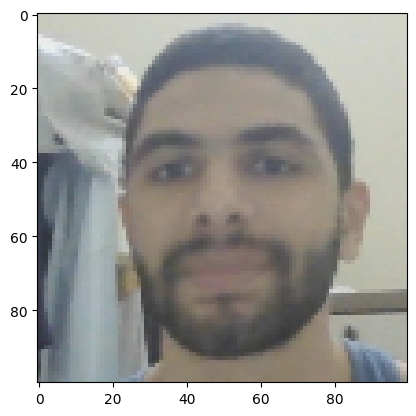

In [79]:
plt.imshow(res[0])

## 3.4. Build Train and Test Partition

In [86]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [87]:
samples = data.as_numpy_iterator() 

In [94]:
example = samples.next()

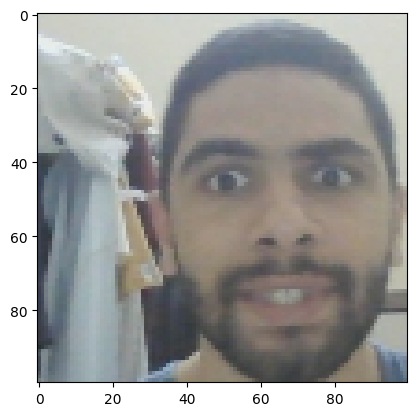

In [95]:
plt.imshow(example[0])

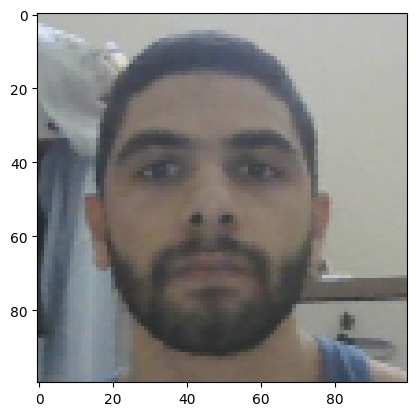

In [96]:
plt.imshow(example[1])

In [97]:
example[2]

1.0

In [98]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [104]:
# now rather than having one image per value we have 16, no. batch
train_sample = train_data.as_numpy_iterator()
train_sample = train_sample.next()
len(train_sample[0])

16

# 4. Model Engineering, Build our model

## 4.1. Build Embedding Layer

### Our core block for building the neural network:

1. Conv2D(no. flitters, filleter size, strokes=1, activation)

2. MaxPooling2D(no. flitters, filleter size, strokes=1, padding),
   * condensing down the amount of data,
   * padding is the same in order to replicate the output shape
  
make_embedding: will translate the input to a feature vector

In [133]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First Block 
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

### Explanation of make_embedding()

In [112]:
inp = Input(shape=(105, 105, 3), name='input_image')
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [113]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d_2')>

In [121]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [122]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [124]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [130]:
print(c4)
print(str(6*6*256))
f1

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='conv2d_8/Relu:0', description="created by layer 'conv2d_8'")
9216


<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten_1')>

In [131]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod

In [132]:
# we are in business guys
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 128)         0 